In [ ]:
# ============================================================
# 1. Imports and basic setup
# ============================================================
import os
import random
import json
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
from PIL import Image, ImageDraw

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from pycocotools.coco import COCO
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# For Colab: mount Google Drive if not yet mounted
from google.colab import drive
drive.mount('/content/drive')

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# nicer plots
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


In [ ]:
# ============================================================
# 2. Paths and class definitions
# ============================================================

DATASET_ROOT = "/content/drive/MyDrive/philippine_currency_dataset"

# IMPORTANT
# Adjust these file names and image folders to match your dataset structure
TRAIN_JSON = os.path.join(DATASET_ROOT, "annotations_train.json")
VAL_JSON   = os.path.join(DATASET_ROOT, "annotations_val.json")
TEST_JSON  = os.path.join(DATASET_ROOT, "annotations_test.json")

TRAIN_IMG_DIR = os.path.join(DATASET_ROOT, "train")
VAL_IMG_DIR   = os.path.join(DATASET_ROOT, "valid")
TEST_IMG_DIR  = os.path.join(DATASET_ROOT, "test")

# Fixed class order for final classifier
CLASS_NAMES = [
    '1000_Pesos',
    '100_Pesos',
    '10_Pesos_New',
    '10_Pesos_Old',
    '1_Coin_New',
    '1_Coin_Old',
    '200_Pesos',
    '20_Coin',
    '20_Pesos',
    '25_Centavo_New',
    '25_Centavo_Old',
    '500_Pesos',
    '50_Pesos',
    '5_Coin_New',
    '5_Coin_Old',
    'Polymer_1000_Pesos'
]
NUM_CLASSES = len(CLASS_NAMES)

In [ ]:

# ============================================================
# 3. Helper to build label mapping from COCO categories
# ============================================================

def build_category_mappings(coco_obj):
    """
    Builds mappings
      cat_id_to_label: COCO category id -> 0..NUM_CLASSES-1
      label_to_cat_id: 0..NUM_CLASSES-1 -> COCO category id
    Uses CLASS_NAMES order.
    """
    cat_id_to_label = {}
    label_to_cat_id = {}

    # Map COCO categories by name
    name_to_cat_id = {c["name"]: c["id"] for c in coco_obj.loadCats(coco_obj.getCatIds())}

    for label_idx, class_name in enumerate(CLASS_NAMES):
        if class_name not in name_to_cat_id:
            raise ValueError(f"Class name {class_name} not found in COCO categories")
        cat_id = name_to_cat_id[class_name]
        cat_id_to_label[cat_id] = label_idx
        label_to_cat_id[label_idx] = cat_id

    return cat_id_to_label, label_to_cat_id



In [ ]:
# ============================================================
# 4. Sampling options
# ============================================================

SAMPLE_MODE = False        # True = sample (balanced subset)
                           # False = use all images from JSON
TRAIN_SAMPLES_PER_CLASS = 100
VAL_SAMPLES_PER_CLASS   = 20


# ============================================================
# 5. Helper functions for sampling and visualization
# ============================================================

def stratified_sample_from_coco(json_path, n_per_class, cat_id_to_label):
    """
    Randomly sample up to n_per_class images per category.
    Returns: list of dict samples + COCO object
    """
    coco = COCO(json_path)

    # Map category → image_id → bbox
    cat_to_img_bbox = defaultdict(dict)

    for ann_id, ann in coco.anns.items():
        cat_id = ann["category_id"]
        if cat_id not in cat_id_to_label:
            continue

        img_id = ann["image_id"]
        if img_id not in cat_to_img_bbox[cat_id]:
            cat_to_img_bbox[cat_id][img_id] = ann["bbox"]

    samples = []

    for cat_id, img_dict in cat_to_img_bbox.items():
        img_ids = list(img_dict.keys())
        random.shuffle(img_ids)

        if len(img_ids) > n_per_class:
            selected = img_ids[:n_per_class]
        else:
            selected = img_ids

        for img_id in selected:
            img_info = coco.loadImgs(img_id)[0]
            bbox = img_dict[img_id]
            label = cat_id_to_label[cat_id]

            samples.append({
                "image_id": img_id,
                "file_name": img_info["file_name"],
                "category_id": cat_id,
                "label": label,
                "bbox": bbox
            })

    print(f"[SAMPLED] {len(samples)} images from {json_path}")
    return samples, coco


def build_all_samples(json_path, cat_id_to_label):
    """
    No sampling – use ALL annotations in the JSON file.
    Each annotation becomes one sample.
    """
    coco = COCO(json_path)
    samples = []

    for ann_id, ann in coco.anns.items():
        cat_id = ann["category_id"]
        if cat_id not in cat_id_to_label:
            continue

        img_id = ann["image_id"]
        img_info = coco.loadImgs(img_id)[0]

        label = cat_id_to_label[cat_id]
        bbox = ann["bbox"]

        samples.append({
            "image_id": img_id,
            "file_name": img_info["file_name"],
            "category_id": cat_id,
            "label": label,
            "bbox": bbox
        })

    print(f"[FULL] {len(samples)} images from {json_path}")
    return samples, coco


def plot_class_distribution(samples, title):
    """
    Bar plot of class counts for visual inspection.
    """
    labels = [s["label"] for s in samples]
    counts = Counter(labels)
    counts_list = [counts.get(i, 0) for i in range(len(CLASS_NAMES))]

    plt.figure(figsize=(10, 4))
    plt.bar(range(len(CLASS_NAMES)), counts_list)
    plt.xticks(range(len(CLASS_NAMES)), CLASS_NAMES, rotation=90)
    plt.ylabel("Count")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def visualize_samples_with_bbox(samples, img_dir, num_images=6):
    """
    Show original images with their bounding box drawn.
    """
    num_images = min(num_images, len(samples))
    chosen = random.sample(samples, num_images)

    cols = min(num_images, 3)
    rows = int(np.ceil(num_images / cols))

    plt.figure(figsize=(5 * cols, 4 * rows))
    for i, sample in enumerate(chosen):
        img_path = os.path.join(img_dir, sample["file_name"])
        img = Image.open(img_path).convert("RGB")
        draw = ImageDraw.Draw(img)

        bbox = sample.get("bbox", None)
        if bbox is not None:
            x, y, w, h = bbox
            x1 = int(x)
            y1 = int(y)
            x2 = int(x + w)
            y2 = int(y + h)
            draw.rectangle([x1, y1, x2, y2], outline="red", width=3)

        label_idx = sample["label"]
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(CLASS_NAMES[label_idx])
    plt.tight_layout()
    plt.show()


def visualize_crop_strategy(sample, img_dir):
    """
    Side by side: original with bbox vs cropped and resized.
    """
    img_path = os.path.join(img_dir, sample["file_name"])
    img = Image.open(img_path).convert("RGB")

    # original with bbox
    img_orig = img.copy()
    draw = ImageDraw.Draw(img_orig)
    bbox = sample.get("bbox", None)
    if bbox is not None:
        x, y, w, h = bbox
        x1 = int(x)
        y1 = int(y)
        x2 = int(x + w)
        y2 = int(y + h)
        draw.rectangle([x1, y1, x2, y2], outline="red", width=3)

    # cropped and resized (without normalization)
    if bbox is not None:
        x, y, w, h = bbox
        x1 = max(int(x), 0)
        y1 = max(int(y), 0)
        x2 = min(int(x + w), img.width)
        y2 = min(int(y + h), img.height)
        if x2 > x1 and y2 > y1:
            img_crop = img.crop((x1, y1, x2, y2))
        else:
            img_crop = img
    else:
        img_crop = img

    img_crop_resized = img_crop.resize((224, 224))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_orig)
    plt.axis("off")
    plt.title("Original with bbox")

    plt.subplot(1, 2, 2)
    plt.imshow(img_crop_resized)
    plt.axis("off")
    plt.title("Cropped and resized 224x224")
    plt.tight_layout()
    plt.show()


def visualize_model_diagram():
    """
    Simple block diagram of the hybrid architecture.
    """
    plt.figure(figsize=(8, 5))
    plt.axis("off")

    # Draw text boxes
    plt.text(0.1, 0.7, "Input image\n(224x224x3)", bbox=dict(boxstyle="round", fc="lightblue"), ha="center")
    plt.text(0.4, 0.7, "ResNet18\nconv backbone\n(7x7x512)", bbox=dict(boxstyle="round", fc="lightgreen"), ha="center")
    plt.text(0.7, 0.7, "Flatten to tokens\n(49 x 512)\n+ positional encoding", bbox=dict(boxstyle="round", fc="lightyellow"), ha="center")
    plt.text(0.4, 0.3, "Transformer encoder\nself attention", bbox=dict(boxstyle="round", fc="lightpink"), ha="center")
    plt.text(0.7, 0.3, "Mean pooling\n(1 x 512)\nClassifier (16 classes)", bbox=dict(boxstyle="round", fc="wheat"), ha="center")

    # Draw arrows
    def arrow(x1, y1, x2, y2):
        plt.annotate("", xy=(x2, y2), xytext=(x1, y1),
                     arrowprops=dict(arrowstyle="->", lw=2))

    arrow(0.18, 0.7, 0.32, 0.7)
    arrow(0.48, 0.7, 0.62, 0.7)
    arrow(0.7, 0.64, 0.7, 0.36)
    arrow(0.32, 0.3, 0.28, 0.3)
    arrow(0.48, 0.3, 0.62, 0.3)

    plt.title("ResNet18 plus Transformer hybrid architecture", pad=20)
    plt.show()



In [ ]:
# ============================================================
# 6. Build the TRAIN, VAL, TEST lists based on SAMPLE_MODE
# ============================================================

# Build category mappings first
coco_train_tmp = COCO(TRAIN_JSON)
cat_id_to_label, label_to_cat_id = build_category_mappings(coco_train_tmp)

if SAMPLE_MODE:
    # balanced sampling
    train_samples, _ = stratified_sample_from_coco(
        TRAIN_JSON,
        TRAIN_SAMPLES_PER_CLASS,
        cat_id_to_label
    )
    val_samples, _ = stratified_sample_from_coco(
        VAL_JSON,
        VAL_SAMPLES_PER_CLASS,
        cat_id_to_label
    )
else:
    # full dataset
    train_samples, _ = build_all_samples(TRAIN_JSON, cat_id_to_label)
    val_samples, _   = build_all_samples(VAL_JSON,   cat_id_to_label)

# Test set is usually full, but you can also toggle this if needed
test_samples, _ = build_all_samples(TEST_JSON, cat_id_to_label)

print(f"Number of train samples: {len(train_samples)}")
print(f"Number of val samples:   {len(val_samples)}")
print(f"Number of test samples:  {len(test_samples)}")


loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
[FULL] 26187 images from /content/drive/MyDrive/philippine_currency_dataset/annotations_train.json
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
[FULL] 2793 images from /content/drive/MyDrive/philippine_currency_dataset/annotations_val.json
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
[FULL] 2140 images from /content/drive/MyDrive/philippine_currency_dataset/annotations_test.json
Number of train samples: 26187
Number of val samples:   2793
Number of test samples:  2140


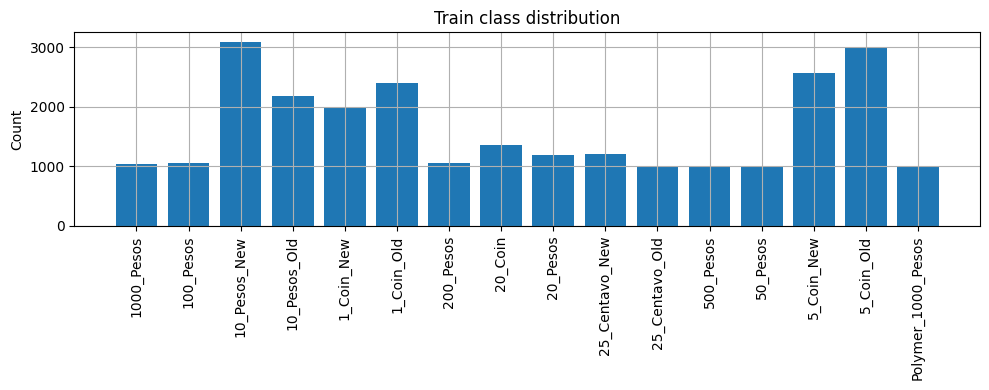

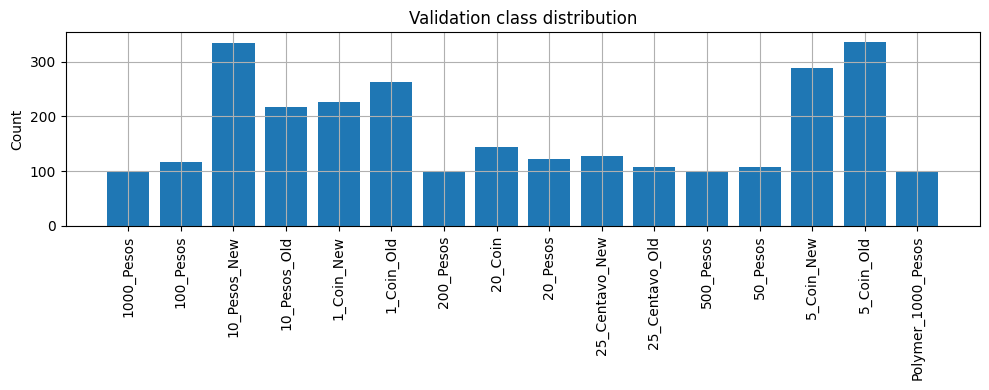

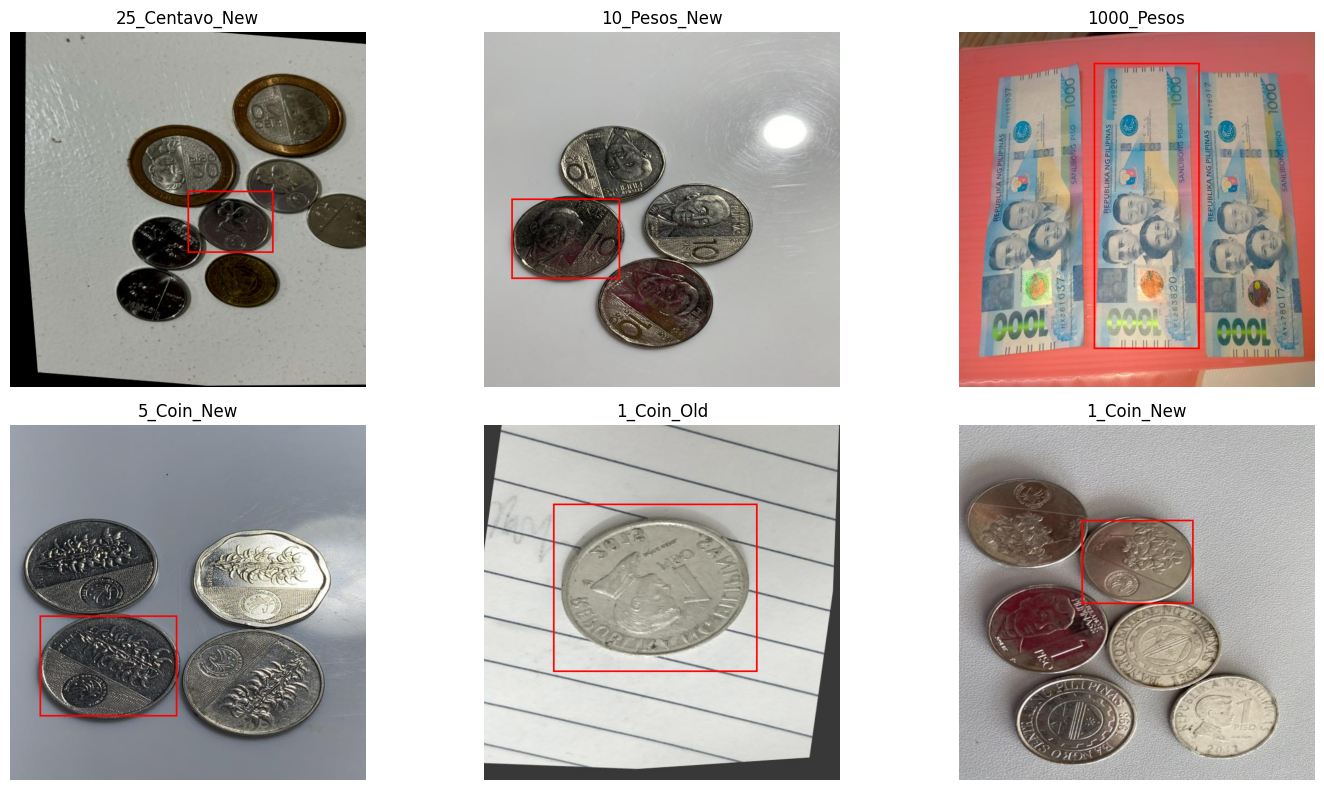

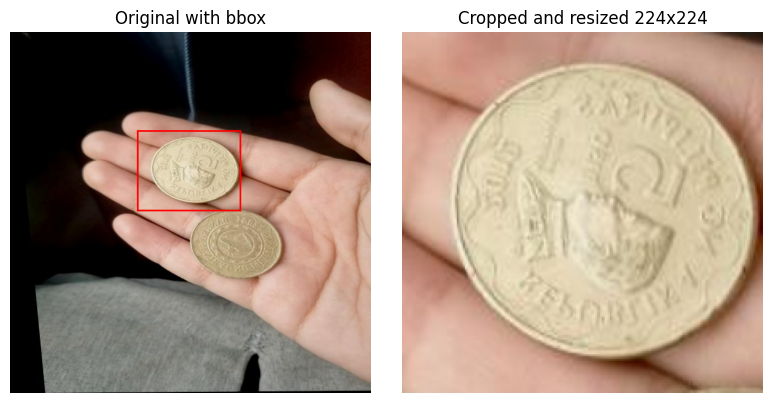

In [ ]:
# ============================================================
# 7. Visual inspection of dataset and sampling
# ============================================================

# Class distribution plots
plot_class_distribution(train_samples, "Train class distribution")
plot_class_distribution(val_samples, "Validation class distribution")

# Show some train images with bounding boxes
visualize_samples_with_bbox(train_samples, TRAIN_IMG_DIR, num_images=6)

# Show crop strategy on one random sample
if len(train_samples) > 0:
    visualize_crop_strategy(random.choice(train_samples), TRAIN_IMG_DIR)

# # Visual explanation of the architecture fusion
# visualize_model_diagram()



In [ ]:
# ============================================================
# 8. Custom Dataset for cropped currency classification
# ============================================================

class CurrencyClassificationDataset(Dataset):
    def __init__(self, img_root, samples, transform=None):
        """
        img_root: folder containing the images
        samples: list of dictionaries {file_name, bbox, label}
        """
        self.img_root = img_root
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        img_path = os.path.join(self.img_root, sample["file_name"])

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Crop using bbox [x, y, w, h]
        bbox = sample.get("bbox", None)
        if bbox is not None:
            x, y, w, h = bbox
            x1 = max(int(x), 0)
            y1 = max(int(y), 0)
            x2 = min(int(x + w), image.width)
            y2 = min(int(y + h), image.height)
            if x2 > x1 and y2 > y1:
                image = image.crop((x1, y1, x2, y2))

        if self.transform is not None:
            image = self.transform(image)

        label = sample["label"]
        return image, label



In [ ]:
# ============================================================
# 9. Transforms, datasets, and dataloaders
# ============================================================

# ImageNet normalization for ResNet backbone
img_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset = CurrencyClassificationDataset(TRAIN_IMG_DIR, train_samples, transform=img_transforms)
val_dataset   = CurrencyClassificationDataset(VAL_IMG_DIR,   val_samples,   transform=img_transforms)
test_dataset  = CurrencyClassificationDataset(TEST_IMG_DIR,  test_samples,  transform=img_transforms)

BATCH_SIZE = 16

# For Google Drive based data, num_workers=0 is safer
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))

Train batches: 1637
Val batches: 175
Test batches: 134


In [ ]:
# ============================================================
# 10. ResNet18 plus Transformer hybrid model
# ============================================================

class ResNetViTHybrid(nn.Module):
    def __init__(self, num_classes=16):
        super(ResNetViTHybrid, self).__init__()

        # Load pretrained ResNet18 as CNN backbone
        backbone = models.resnet18(pretrained=True)

        # Feature extractor: all layers except the average pool and fully connected layers
        # Output shape for ResNet18 feature map is usually (B, 512, 7, 7) for 224x224 inputs
        self.cnn = nn.Sequential(*list(backbone.children())[:-2])
        self.feature_dim = 512
        self.seq_len = 7 * 7  # spatial tokens

        d_model = self.feature_dim
        nhead = 8
        dim_feedforward = 1024
        num_layers = 1  # one transformer layer for speed on CPU

        # Positional embeddings for 7x7 patch tokens
        self.pos_embedding = nn.Parameter(
            torch.randn(1, self.seq_len, d_model) * 0.02
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # CNN feature map: (B, C, H, W)
        feat_map = self.cnn(x)  # expected shape (B, 512, 7, 7)
        B, C, H, W = feat_map.shape

        # Flatten spatial dimensions to sequence of tokens
        # (B, C, H, W) -> (B, H*W, C)
        x_seq = feat_map.flatten(2).permute(0, 2, 1)

        # Add positional encoding
        pos = self.pos_embedding[:, :H * W, :]
        x_seq = x_seq + pos

        # Self attention encoder
        x_encoded = self.transformer_encoder(x_seq)

        # Global representation by mean pooling over tokens
        x_pooled = x_encoded.mean(dim=1)

        # Final classification head
        logits = self.classifier(x_pooled)
        return logits


# Instantiate model
model = ResNetViTHybrid(num_classes=NUM_CLASSES).to(device)
print(model)



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNetViTHybrid(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [ ]:

# ============================================================
# 11. Training setup
# ============================================================

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

NUM_EPOCHS = 5

train_losses = []
val_accuracies = []



In [ ]:
# ============================================================
# 12. Training loop with printed progress
# ============================================================

for epoch in range(1, NUM_EPOCHS + 1):
    # Training
    model.train()
    running_loss = 0.0
    total_train = 0
    correct_train = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    train_acc = correct_train / total_train

    # Validation
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    val_acc = accuracy_score(all_labels, all_preds)

    train_losses.append(epoch_loss)
    val_accuracies.append(val_acc)

    print(
        f"Epoch {epoch}/{NUM_EPOCHS} | "
        f"Train Loss: {epoch_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )



Epoch 1/5 | Train Loss: 0.2277 | Train Acc: 0.9320 | Val Acc: 0.9864
Epoch 2/5 | Train Loss: 0.0743 | Train Acc: 0.9791 | Val Acc: 0.9842
Epoch 3/5 | Train Loss: 0.0592 | Train Acc: 0.9813 | Val Acc: 0.9871
Epoch 4/5 | Train Loss: 0.0462 | Train Acc: 0.9855 | Val Acc: 0.9731
Epoch 5/5 | Train Loss: 0.0385 | Train Acc: 0.9883 | Val Acc: 0.9864


In [ ]:
# ============================================================
# 13. Test evaluation
# ============================================================

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

test_acc = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {test_acc:.4f}")




Test Accuracy: 0.9907


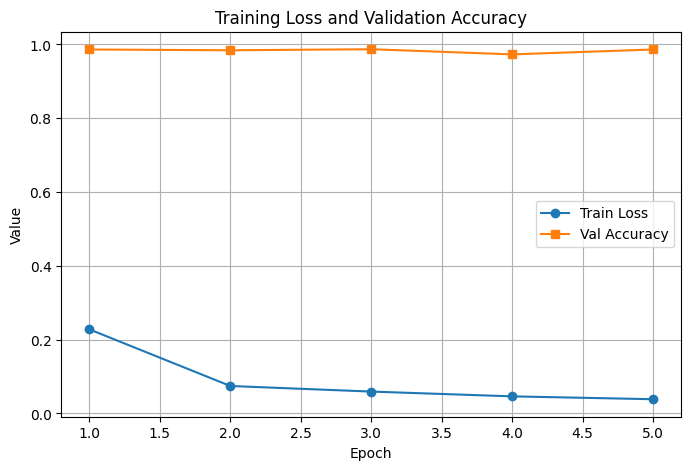

In [ ]:
# ============================================================
# 14. Plot Training Loss and Validation Accuracy
# ============================================================

epochs_range = range(1, NUM_EPOCHS + 1)
plt.figure()
plt.plot(epochs_range, train_losses, marker="o", label="Train Loss")
plt.plot(epochs_range, val_accuracies, marker="s", label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Loss and Validation Accuracy")
plt.legend()
plt.show()

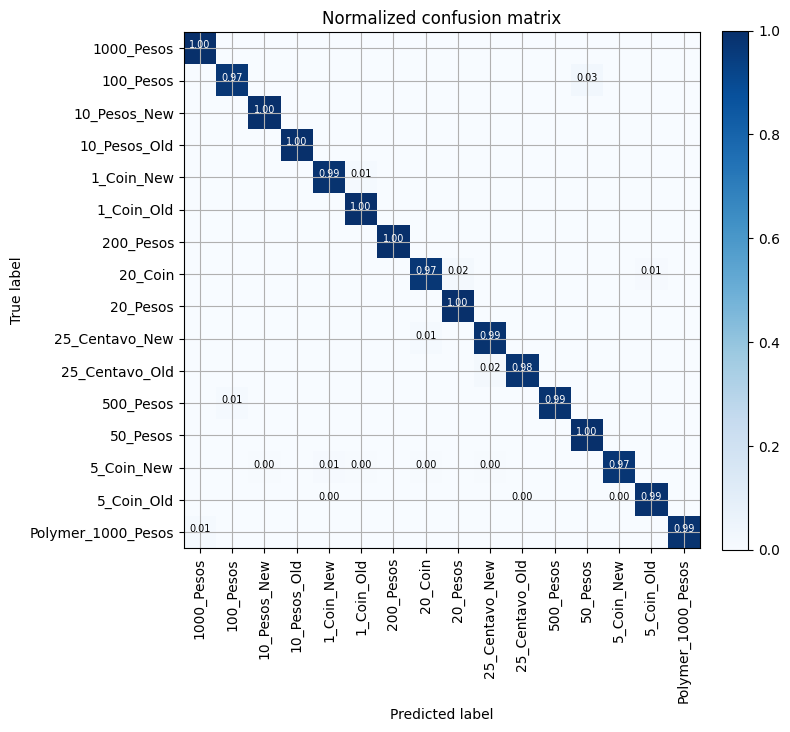

In [ ]:
# ============================================================
# 15. Confusion matrix visualization on test set
# ============================================================

cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 8))
plt.imshow(cm_normalized, interpolation="nearest", cmap="Blues")
plt.title("Normalized confusion matrix")
plt.colorbar(fraction=0.046, pad=0.04)
tick_marks = np.arange(len(CLASS_NAMES))
plt.xticks(tick_marks, CLASS_NAMES, rotation=90)
plt.yticks(tick_marks, CLASS_NAMES)

thresh = cm_normalized.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm_normalized[i, j]
        if value > 0:
            plt.text(j, i, f"{value:.2f}",
                     horizontalalignment="center",
                     color="white" if value > thresh else "black",
                     fontsize=7)

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()



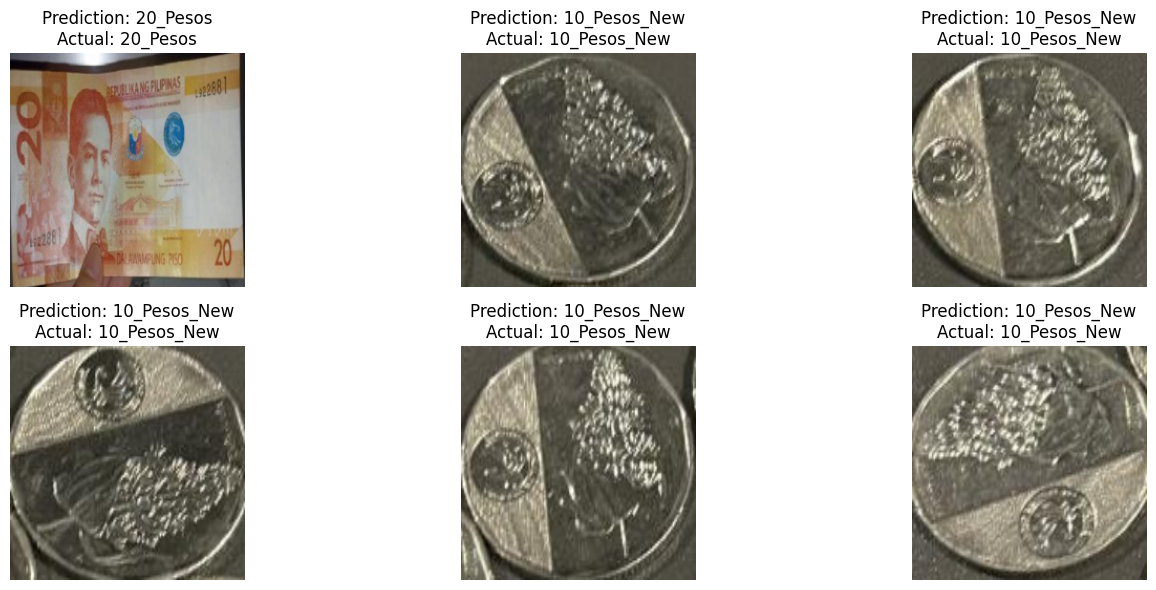

In [ ]:
# ============================================================
# 16. Simple inference function on a random batch from test set
# ============================================================

# Helper to unnormalize for display
inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])],
    std=[1.0 / s for s in [0.229, 0.224, 0.225]]
)

def show_test_batch_predictions(model, test_loader, class_names, max_images=6):
    model.eval()
    images, labels = next(iter(test_loader))  # one batch

    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    images = images.cpu()
    labels = labels.cpu()
    preds = preds.cpu()

    num_show = min(max_images, images.size(0))
    plt.figure(figsize=(15, 6))

    for i in range(num_show):
        img = inv_normalize(images[i])
        img = torch.clamp(img, 0, 1)

        plt.subplot(2, (num_show + 1) // 2, i + 1)
        plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        plt.axis("off")

        pred_label = class_names[preds[i].item()]
        true_label = class_names[labels[i].item()]
        plt.title(f"Prediction: {pred_label}\nActual: {true_label}")

    plt.tight_layout()
    plt.show()

# Run inference visualization
show_test_batch_predictions(model, test_loader, CLASS_NAMES, max_images=6)